#Fetch Rewards Coding Exercise

The below Python script reviews unstructured data in JSON files(brands, receipts, users) and cleans and re-structure it in a tabular format. Some predetermined business questions are answered based on the newly created structured relational model through PostgreSQL. Data quality issues are also identified in this script which are worth mentioning to stakeholders.

##Section 1: Reviewing unstructured data and re-structuring

Pandas library is used to do all the exploration and cleaning of the data. Matplotlib library is used to do the visualization.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

###Receipts

We read the JSON data into a dataframe.

In [2]:
# Reading the receipts.json file
receipts_df = pd.read_json('receipts.json', lines='True')

In [3]:
receipts_df.head()

,_id,bonusPointsEarned,bonusPointsEarnedReason,createDate,dateScanned,finishedDate,modifyDate,pointsAwardedDate,pointsEarned,purchaseDate,purchasedItemCount,rewardsReceiptItemList,rewardsReceiptStatus,totalSpent,userId
0,{'$oid': '5ff1e1eb0a720f0523000575'},500.0,"Receipt number 2 completed, bonus point schedu...",{'$date': 1609687531000},{'$date': 1609687531000},{'$date': 1609687531000},{'$date': 1609687536000},{'$date': 1609687531000},500.0,{'$date': 1609632000000},5.0,"[{'barcode': '4011', 'description': 'ITEM NOT ...",FINISHED,26.0,5ff1e1eacfcf6c399c274ae6
1,{'$oid': '5ff1e1bb0a720f052300056b'},150.0,"Receipt number 5 completed, bonus point schedu...",{'$date': 1609687483000},{'$date': 1609687483000},{'$date': 1609687483000},{'$date': 1609687488000},{'$date': 1609687483000},150.0,{'$date': 1609601083000},2.0,"[{'barcode': '4011', 'description': 'ITEM NOT ...",FINISHED,11.0,5ff1e194b6a9d73a3a9f1052
2,{'$oid': '5ff1e1f10a720f052300057a'},5.0,All-receipts receipt bonus,{'$date': 1609687537000},{'$date': 1609687537000},NaN,{'$date': 1609687542000},NaN,5.0,{'$date': 1609632000000},1.0,"[{'needsFetchReview': False, 'partnerItemId': ...",REJECTED,10.0,5ff1e1f1cfcf6c399c274b0b
3,{'$oid': '5ff1e1ee0a7214ada100056f'},5.0,All-receipts receipt bonus,{'$date': 1609687534000},{'$date': 1609687534000},{'$date': 1609687534000},{'$date': 1609687539000},{'$date': 1609687534000},5.0,{'$date': 1609632000000},4.0,"[{'barcode': '4011', 'description': 'ITEM NOT ...",FINISHED,28.0,5ff1e1eacfcf6c399c274ae6
4,{'$oid': '5ff1e1d20a7214ada1000561'},5.0,All-receipts receipt bonus,{'$date': 1609687506000},{'$date': 1609687506000},{'$date': 1609687511000},{'$date': 1609687511000},{'$date': 1609687506000},5.0,{'$date': 1609601106000},2.0,"[{'barcode': '4011', 'description': 'ITEM NOT ...",FINISHED,1.0,5ff1e194b6a9d73a3a9f1052





 Analyzing the initial dataframe, we see that we need to deal with nested data in column '`rewardsReceiptItemList`', extract '`$oid`' values into the '`_id`' column, and change the datatype of different dates captured, as to better understand the data.

 As synonymous with our ERD, we extract the nested data in '`rewardsReceiptItemList`' into a new table. Each receipt can have multiple Items in it and it is better to have a separate table for items. It is clear that `receipts` table has one-to-many relationship with `items` table.

In [4]:
# Extracting the '$oid' values to '_id' column
receipts_df['_id'] = receipts_df['_id'].apply(lambda x: x['$oid'])

In [5]:
# Function to typecast date(given in ms) to 'datetime' datatype
def typeCast_to_datetime(date):
  try:
    return pd.to_datetime(date['$date'], unit='ms')
  except TypeError:
    return None

In [6]:
# List of columns which are required to be typecasted
date_cols = ['createDate', 'dateScanned', 'finishedDate', 'modifyDate', 'pointsAwardedDate', 'purchaseDate']

# Looping over the columns and calling the typecast function
for i in date_cols:
    receipts_df[i] = receipts_df[i].apply(lambda x: typeCast_to_datetime(x))

We extract '`rewardsReceiptItemList`' column from `receipts_df` into a new dataframe(`items_df`) based on our relational model.

In [7]:
# Extract the 'rewardsReceiptItemList' column values into a new DataFrame
items_df = receipts_df['rewardsReceiptItemList'].explode().apply(pd.Series)
items_df.dropna(axis=1, how='all', inplace=True)

#Concatenate the new DataFrame with the _id of receipts_df
items_df = pd.concat([receipts_df['_id'], items_df], axis=1)

###Users

`Users.json` has similar actions required as we did with `receipts.json`. We extract the `oid` values and convert the date(given in ms) to `datetime` datatype.

In [8]:
# Reading the users.json file
users_df = pd.read_json('users.json', lines=True)

In [9]:
users_df.head()

,_id,active,createdDate,lastLogin,role,signUpSource,state
0,{'$oid': '5ff1e194b6a9d73a3a9f1052'},True,{'$date': 1609687444800},{'$date': 1609687537858},consumer,Email,WI
1,{'$oid': '5ff1e194b6a9d73a3a9f1052'},True,{'$date': 1609687444800},{'$date': 1609687537858},consumer,Email,WI
2,{'$oid': '5ff1e194b6a9d73a3a9f1052'},True,{'$date': 1609687444800},{'$date': 1609687537858},consumer,Email,WI
3,{'$oid': '5ff1e1eacfcf6c399c274ae6'},True,{'$date': 1609687530554},{'$date': 1609687530597},consumer,Email,WI
4,{'$oid': '5ff1e194b6a9d73a3a9f1052'},True,{'$date': 1609687444800},{'$date': 1609687537858},consumer,Email,WI


In [10]:
# Extracting the '$oid' values to '_id' column
users_df['_id'] = users_df['_id'].apply(lambda x: x['$oid'])

In [11]:
# List of columns which are required to be typecasted
date_cols = ['createdDate', 'lastLogin']

# Looping over the columns and calling the typecast function
for i in date_cols:
  users_df[i] = users_df[i].apply(lambda x: typeCast_to_datetime(x))

###Brands

Here, we extract the '`$oid`' values into the '`_id`' column and deal with the nested data in column '`cpg`'. To convert it to more structured schema, we extract the '`cpg`' values into a new dataframe(`cpg_df`) and then merge it back to the `brands_df` dataframe as there is one-to-one relationship between them.

In [12]:
# Reading the brands.json file
brands_df = pd.read_json('brands.json', lines=True)

In [13]:
brands_df.head()

,_id,barcode,category,categoryCode,cpg,name,topBrand,brandCode
0,{'$oid': '601ac115be37ce2ead437551'},511111019862,Baking,BAKING,"{'$id': {'$oid': '601ac114be37ce2ead437550'}, ...",test brand @1612366101024,0.0,NaN
1,{'$oid': '601c5460be37ce2ead43755f'},511111519928,Beverages,BEVERAGES,"{'$id': {'$oid': '5332f5fbe4b03c9a25efd0ba'}, ...",Starbucks,0.0,STARBUCKS
2,{'$oid': '601ac142be37ce2ead43755d'},511111819905,Baking,BAKING,"{'$id': {'$oid': '601ac142be37ce2ead437559'}, ...",test brand @1612366146176,0.0,TEST BRANDCODE @1612366146176
3,{'$oid': '601ac142be37ce2ead43755a'},511111519874,Baking,BAKING,"{'$id': {'$oid': '601ac142be37ce2ead437559'}, ...",test brand @1612366146051,0.0,TEST BRANDCODE @1612366146051
4,{'$oid': '601ac142be37ce2ead43755e'},511111319917,Candy & Sweets,CANDY_AND_SWEETS,"{'$id': {'$oid': '5332fa12e4b03c9a25efd1e7'}, ...",test brand @1612366146827,0.0,TEST BRANDCODE @1612366146827


In [14]:
# Extracting the '$oid' values to '_id' column
brands_df['_id'] = brands_df['_id'].apply(lambda x: x['$oid'])

In [15]:
# Extract the 'cpg' column values into a new DataFrame
cpg_df = pd.DataFrame(brands_df['cpg'].tolist())

cpg_df['$id'] = cpg_df['$id'].apply(lambda x: x['$oid'])

In [16]:
#Merging the two dataframes as they have one to one relationship
brands_df = pd.concat([brands_df, cpg_df], axis=1)

##Section 2: Queries answering predetermined questions from stakeholder.

Here we use PostgresSQL and our ERD to answer some queries. I have separately committed a sql file as well for these queries.

What are the top 5 brands by receipts scanned for most recent month?

In [18]:
# SELECT i.brandCode AS brandCode, COUNT(r._id) AS receiptCount
# FROM Items AS i
# JOIN (SELECT _id
#       FROM Receipts
#       WHERE dateScanned >= DATE_TRUNC('month', CURRENT_DATE) -- Filter for the most recent month
# ) AS r ON i.receiptId = r._id
# GROUP BY b._id, b.name
# ORDER BY receipt_count DESC
# LIMIT 5;

When considering average spend from receipts with 'rewardsReceiptStatus’ of ‘Accepted’ or ‘Rejected’, which is greater?

In [19]:
# SELECT rewardsReceiptStatus, AVG(totalSpent) AS averageSpend
# FROM Receipts
# WHERE rewardsReceiptStatus =  (SELECT CASE
#                               WHEN
#                               (SELECT avg(totalSpent) FROM Receipts WHERE rewardsReceiptStatus='REJECTED')
#                               >
#                               (SELECT avg(totalSpent) FROM Receipts WHERE rewardsReceiptStatus='FINISHED')
#                               THEN 'REJECTED'
#                               ELSE 'FINISHED'
#                               END AS statusHighestAvgSpent
#                               )
# GROUP BY rewardsReceiptStatus;


Which brand has the most spend among users who were created within the past 6 months?

In [20]:
# SELECT i.brandCode AS brandCode, SUM(r.totalSpent) AS total_spend
# FROM Items AS i
# JOIN Receipts AS r ON i.receiptId = r._id
# JOIN (
#    SELECT _id
#    FROM Users
#    WHERE createdDate >= (CURRENT_DATE - INTERVAL '6' MONTH) -- Filter for users created within the past 6 months
# ) AS u ON r.userId = u._id
# GROUP BY b._id, b.name
# ORDER BY total_spend DESC
# LIMIT 1;


Which brand has the most transactions among users who were created within the past 6 months?

In [21]:
# SELECT i.brandCode AS brandCode, COUNT(r._id) AS transaction_count
# FROM Items AS i
# JOIN Receipts AS r ON i.receiptId = r._id
# JOIN (
#    SELECT _id
#    FROM Users
#    WHERE createdDate >= (CURRENT_DATE - INTERVAL '6' MONTH) -- Filter for users created within the past 6 months
# ) AS u ON r.userId = u._id
# GROUP BY b._id, b.name
# ORDER BY total_spend DESC
# LIMIT 1;

##Data Quality Check

To analyze the data quality:

*   We check the null value percentage for columns in all the tables.
*   We check for outliers.
*   We check for duplicate data.
*   We check if datatype is consistent - some of the float values are stored as string





###Checking null values

In [22]:
# Calculate the percentage of null values in each column of brands_df
null_percentage_brands = brands_df.isnull().mean() * 100
print(null_percentage_brands)

_id              0.000000
barcode          0.000000
category        13.281919
categoryCode    55.698372
cpg              0.000000
name             0.000000
topBrand        52.442159
brandCode       20.051414
$id              0.000000
$ref             0.000000
dtype: float64



Analyzing the data quality and issues caused by that -

*   Here we can see that there are null values in `brandCode`, which is a problem because we join `Brands` and `Items` table by `brandCode` column.
*   There is inconsistencies in values of `categoryCode`. For the same `category`, some have correct `categoryCode` and some values are null.


We need to examine the source of `Brands` table in order to better understand the reasons behind these data quality issues and fix them.

In [23]:
# Calculate the percentage of null values in each column of receipts_df
null_percentage_receipts = receipts_df.isnull().mean() * 100
print(null_percentage_receipts)

_id                         0.000000
bonusPointsEarned          51.385165
bonusPointsEarnedReason    51.385165
createDate                  0.000000
dateScanned                 0.000000
finishedDate               49.240393
modifyDate                  0.000000
pointsAwardedDate          52.010724
pointsEarned               45.576408
purchaseDate               40.035746
purchasedItemCount         43.252904
rewardsReceiptItemList     39.320822
rewardsReceiptStatus        0.000000
totalSpent                 38.873995
userId                      0.000000
dtype: float64


Some insights on the data quality and the potential issues that can be caused due it -

*   There is significant percentage of values missing for `pointsEarned`, `bonusPointsEarned`, and `purchasedItemCount`.
*   Queries like - top 5 items which are bought/scanned the most, or top 5 users who have the most points earned, will give us incorrect result because of these missing values



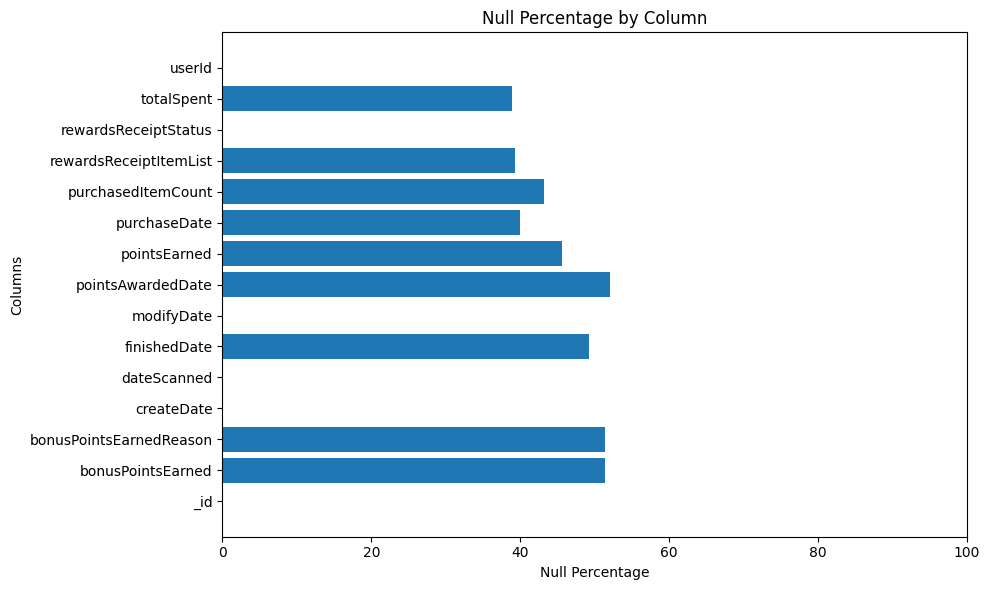

In [24]:
# plotting a chart of null values percentage for each column in receipts_df
plt.figure(figsize=(10, 6))
plt.barh(null_percentage_receipts.index, null_percentage_receipts.values)
plt.xlim(0, 100)
plt.xlabel('Null Percentage')
plt.ylabel('Columns')
plt.title('Null Percentage by Column')
plt.tight_layout()
plt.show()

In [25]:
# Calculate the percentage of null values in each column of users_df
null_percentage_users = users_df.isnull().mean() * 100
print(null_percentage_users)

_id              0.000000
active           0.000000
createdDate      0.000000
lastLogin       12.525253
role             0.000000
signUpSource     9.696970
state           11.313131
dtype: float64


In [26]:
# Calculate the percentage of null values in each column of items_df
null_percentage_items = items_df.isnull().mean() * 100
print(null_percentage_items)

_id                                    0.000000
barcode                               58.135754
description                           11.123154
finalPrice                             8.318656
itemPrice                              8.318656
needsFetchReview                      88.985232
partnerItemId                          5.961252
preventTargetGapPoints                95.149709
quantityPurchased                      8.318656
userFlaggedBarcode                    95.434223
userFlaggedNewItem                    95.623899
userFlaggedPrice                      95.949058
userFlaggedQuantity                   95.949058
needsFetchReviewReason                97.032922
pointsNotAwardedReason                95.393578
pointsPayerId                         82.834304
rewardsGroup                          76.547893
rewardsProductPartnerId               69.258908
userFlaggedDescription                97.222599
originalMetaBriteBarcode              99.038071
originalMetaBriteDescription          99

Checking the data quality for items_df, we find that -



*   There are lot of columns with significant percentage of null values. `brandCode` has 64% null values, as explained earlier, null values in this column will give us incorrect data when we perform join operations on `Items` and `Brands` table.
*   Assuming that this data is coming from the application, we need to check why we are not able to capture values for so many data points.



###Checking for duplicate data

In [27]:
# We check if there are duplicate rows for receipts_df
receipts_df.drop(columns=['rewardsReceiptItemList'], axis=1, inplace=True)
duplicateRows_receipts = receipts_df[receipts_df.duplicated()]
print(duplicateRows_receipts)

Empty DataFrame
Columns: [_id, bonusPointsEarned, bonusPointsEarnedReason, createDate, dateScanned, finishedDate, modifyDate, pointsAwardedDate, pointsEarned, purchaseDate, purchasedItemCount, rewardsReceiptStatus, totalSpent, userId]
Index: []


In [28]:
# We check if there are duplicate rows for users_df
duplicateRows_users = users_df[users_df.duplicated()]
print(duplicateRows_users)

                          _id  active             createdDate  \
1    5ff1e194b6a9d73a3a9f1052    True 2021-01-03 15:24:04.800   
2    5ff1e194b6a9d73a3a9f1052    True 2021-01-03 15:24:04.800   
4    5ff1e194b6a9d73a3a9f1052    True 2021-01-03 15:24:04.800   
5    5ff1e194b6a9d73a3a9f1052    True 2021-01-03 15:24:04.800   
8    5ff1e194b6a9d73a3a9f1052    True 2021-01-03 15:24:04.800   
..                        ...     ...                     ...   
490  54943462e4b07e684157a532    True 2014-12-19 14:21:22.381   
491  54943462e4b07e684157a532    True 2014-12-19 14:21:22.381   
492  54943462e4b07e684157a532    True 2014-12-19 14:21:22.381   
493  54943462e4b07e684157a532    True 2014-12-19 14:21:22.381   
494  54943462e4b07e684157a532    True 2014-12-19 14:21:22.381   

                  lastLogin         role signUpSource state  
1   2021-01-03 15:25:37.858     consumer        Email    WI  
2   2021-01-03 15:25:37.858     consumer        Email    WI  
4   2021-01-03 15:25:37.858     c

In the users table -


*   We can see that there are 283 duplicated rows.
*   We need to check why is the case, are we capturing data more frequently than required or we are not updating the table correctly.




In [29]:
# We check if there are duplicate rows for brands_df
brands_df.drop(columns=['cpg'], axis=1, inplace=True)
duplicateRows_brands = brands_df[brands_df.duplicated()]
print(duplicateRows_brands)

Empty DataFrame
Columns: [_id, barcode, category, categoryCode, name, topBrand, brandCode, $id, $ref]
Index: []


##Section 4: Communication with stakeholder

Subject: Concerns Regarding Data Quality and Optimization Opportunities

Hello all,

I hope this message finds you well. I wanted to bring your attention to some significant findings and considerations concerning the Rewards data that I have been working with. I also have some questions regarding the data that I would appreciate clarification on.

1. Data-related Questions:
* Can you please specify the source of the brands.json file? Understanding this will help us address the missing values in the brandCode field, which is crucial for our analysis.
* I would like to know how data is being captured in Users.json. A significant portion of the data appears to be redundant, so it is important to determine if we are capturing it more frequently than necessary or if there are any inaccuracies in the data capture process.

2. Data Quality Issues:
* During basic data quality checks, I identified null values in key columns such as barCode and brandCode in the items list. If these null values are not addressed, our queries could produce inaccurate results. For instance, queries like "find brands with the most receipts scanned for the past month" or "find brands with the most sales" may yield incorrect data.
* More than half of the data in Users.json seems to be duplicate, which can lead to inefficient joins and unnecessarily high storage usage.
* While examining the receipts data, I noticed some outlier entries where transactions indicated purchases of over 450 items and earning of more than 750 points. I would like to confirm if such events are possible or if this data is erroneous.

3. Resolving the Issues:

   In order to address these concerns, it is essential to investigate the sources of the JSON files to ensure accurate data capture. If the inflow of data into the JSON files is verified, we can then handle the null values and redundant data before storing it in the data warehouse.

4. Additional Information for Optimization:

   It would be helpful to have more details about our objectives with this relational model. For example, if we intend to perform numerous ad-hoc analyses, we can focus on optimizing query performance accordingly.

5. Performance and Scaling Concerns:

   In production, potential performance and scaling concerns may arise due to the growing dataset. To address these concerns, we can implement indexes on frequently queried columns, optimize database queries, and consider horizontal scaling techniques by leveraging distributed servers or cloud-based solutions. Additionally, we can analyze query plans, optimize SQL queries, and explore data denormalization techniques to enhance query performance and efficiency.

Addressing these data quality issues and optimizing the data assets will significantly enhance the value and reliability of our analyses. Your insights and guidance are crucial in achieving the desired outcomes. Please share your thoughts, provide any additional information that may be required, or let me know if you would like to discuss these findings further.

Thank you for your attention to this matter.

Regards,

Sumit